# IMDB Sentiment Classifier Multi-Convolutional

#### Load dependencies

In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model #new!
from keras.layers import Input, concatenate # to concatenate conv. layers together
from keras.layers import Dense,  Dropout, Conv1D, GlobalMaxPooling1D, SpatialDropout1D, Embedding 
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\moi\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Set Hyperparameters 

In [2]:
output_dir='model_output/multiconv'

epochs=4
batch_size=128 #mini b.s. for Gradient Descent, for start

# for Vector Space Embeddings: 
n_dim=64 # number of dimensions
n_unique_words = 5000
max_review_length =400 # if review has more than 400 words: truncate

drop_embed=0.2  #dropout into the embedding layer, 20%; 
pad_type=  trunc_type='pre' # kind of padding / truncating'



#### NN architecture 

In [3]:
n_dense=256
dropout=0.2

n_conv_1=n_conv_2=n_conv_3 = 256 # nr of kernels
k_conv_1=3  # size of the filter, 1-dimensional; sequences of 3 words in a row
k_conv_2=2
k_conv_3=4

#### Load data 

in one line: 
* set the max. number of tokens in each of documents, 
* filters out punctuation, 
* sets all tokens to lowercase, 
* converts all words into an integer index
<br>
= keras.preprocessing.text.Tokenizer

In [4]:
(X_train, y_train), (X_test, y_test) =  imdb.load_data(num_words=n_unique_words)
                                #no skipped words, they can be important)

#### Restore words from index 

In [5]:
word_index=keras.datasets.imdb.get_word_index()
word_index={k:(v+3) for k,v in word_index.items()}
word_index['PAD']=0
word_index['START']=1
word_index['UNK']=2

In [6]:
word_index={v:k for k,v in word_index.items()}
word_index[215]

'must'

In [7]:

(w_x_train,_), (w_x_valid,_)=imdb.load_data()

#### Preprocess data 
sequences longer than 400 will bo truncated, shorter will be padded<br>
truncate the front ('pre')

In [8]:
X_train=pad_sequences(X_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type)
X_test=pad_sequences(X_test, maxlen=max_review_length, padding=pad_type, truncating=trunc_type)

#### Design NN architecture
non-sequential model,  <br> 
embedding layer will pass into 3 different conv. layers, <br> 

In [9]:

input_layer=Input(shape=(max_review_length,), dtype='int16', name='input')
# here shape not automatically 

embedding_layer=Embedding(n_unique_words, n_dim, input_length=max_review_length, name='embedding'
                         )(input_layer)

# the second set of paranthesis: feeding layer
drop_embedding_layer=SpatialDropout1D(drop_embed, name='drop_embed')(embedding_layer)

conv_1=Conv1D(n_conv_1, k_conv_1, activation='relu', name='conv_1')(drop_embedding_layer)
maxp_1=GlobalMaxPooling1D(name='maxp1')(conv_1)

conv_2=Conv1D(n_conv_2, k_conv_2, activation='relu', name='conv_2')(drop_embedding_layer)
maxp_2=GlobalMaxPooling1D(name='maxp2')(conv_2)

conv_3=Conv1D(n_conv_3, k_conv_3, activation='relu', name='conv_3')(drop_embedding_layer)
maxp_3=GlobalMaxPooling1D(name='maxp3')(conv_3)

concat=concatenate([maxp_1, maxp_2, maxp_3])
# puts them side by side, for input into the dense layer coming up

dense_layer_1=Dense(n_dense, activation='relu', name='dense_1')(concat)
drop_dense_layer_1=Dropout(dropout, name='drop_dense_1')(dense_layer_1)

#just for fun:
dense_layer_2=Dense(n_dense, activation='relu', name='dense_2')(drop_dense_layer_1)
drop_dense_layer_2=Dropout(dropout, name='drop_dense_2')(dense_layer_2)

predictions=Dense(1, activation='sigmoid', name='output')(drop_dense_layer_2)

#and specify now the actual model, now at the end
model=Model(input_layer, predictions)


reviews fitted into embedding layer, which converts the language into **vector space embedding**
<br>Dense layer will learn which word vector representations are predictive of whether it is a positive or negative review


In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 400)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 64)      320000      input[0][0]                      
__________________________________________________________________________________________________
drop_embed (SpatialDropout1D)   (None, 400, 64)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 398, 256)     49408       drop_embed[0][0]                 
__________________________________________________________________________________________________
conv_2 (Co

#### Configure the model 

In [11]:
model.compile(
    loss='binary_crossentropy',    #what kind of loss we are going to have, this is v. efficient
                                   # przy MNIST był categorical_crossentropy - for multiclass problems    
    optimizer='adam',
    metrics=['accuracy'])  

In [12]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [13]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train

In [14]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 420s 17ms/step - loss: 0.4862 - acc: 0.7340 - val_loss: 0.2837 - val_acc: 0.8818
Epoch 2/4
25000/25000 [==============================] - 415s 17ms/step - loss: 0.2424 - acc: 0.9036 - val_loss: 0.2543 - val_acc: 0.8946
Epoch 3/4
25000/25000 [==============================] - 396s 16ms/step - loss: 0.1657 - acc: 0.9392 - val_loss: 0.2763 - val_acc: 0.8888
Epoch 4/4
25000/25000 [==============================] - 390s 16ms/step - loss: 0.1228 - acc: 0.9578 - val_loss: 0.2922 - val_acc: 0.8954


#### Evaluate 

In [34]:
model.load_weights(output_dir+'/weights.04.hdf5') 

In [35]:
y_hat=model.predict(X_test)

In [36]:
y_hat[1]

array([0.9978816], dtype=float32)

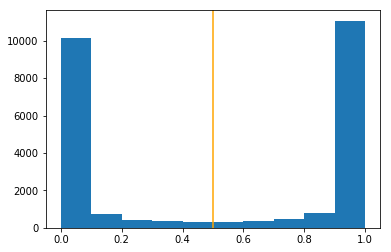

In [37]:
plt.hist(y_hat)
_=plt.axvline(x=0.5, color='orange')


In [38]:
pct_auc=roc_auc_score(y_test, y_hat)*100
pct_auc

96.1329968

In [39]:
'{:0.2f}'.format(pct_auc)

'96.13'

In [43]:
float_y_hat=[]
for i in y_hat:
    float_y_hat.append(i[0])

In [44]:
a=list(y_hat)

In [45]:
ydf=pd.DataFrame(list(zip(float_y_hat, y_test)), columns=['y_hat', 'y'])

In [46]:
ydf.head(20)

,y_hat,y
0,0.115143,0
1,0.997882,1
2,0.993571,1
3,0.671492,0
4,0.999385,1
5,0.975747,1
6,0.997216,1
7,0.003439,0
8,0.997045,0
9,0.994320,1


review with best score:

In [47]:
' '.join(word_index[id] for id in w_x_valid[14])

'START a touching documentary that puts a human face on the tragedy of 9 11 by showing how one small community to honor two high school friends lost on that day the film interweaves the lives of chris and tom through interviews with family and friends and snippets of old photos through their reminiscences we glimpse two lives tragically cut short the film also documents how through a series of coincidences an inspirational memorial garden was brought forth through the efforts of many people both known and unknown to the two victims through the laughter and the tears and the sweat we see the power of hope and honor and love this films evokes many different emotions but the final feeling is one of admiration of the human spirit by tragedy'

the misclassified reviews 

In [48]:
wrongs=ydf[(ydf.y==0)&(ydf.y_hat>0.9)]

In [49]:
len(wrongs)

741

In [50]:
wrongs.head()

,y_hat,y
8,0.997045,0
13,0.978357,0
17,0.917876,0
78,0.952834,0
154,0.958692,0


In [51]:
' '.join(word_index[id] for id in w_x_valid[8])

"START hollywood had a long love affair with bogus arabian nights tales but few of these products have stood the test of time the most memorable were the jon hall maria montez films which have long since become camp this one is filled with dubbed songs anachronistic slang and slapstick it's a truly crop of corn and pretty near intolerable today it was nominated for its imaginative special effects which are almost unnoticeable in this day and age consisting mainly of trick photography the only outstanding positive feature which survives is its beautiful color and clarity sad to say of the many films made in this genre few of them come up to alexander korda's original thief of baghdad almost any other arabian nights film is superior to this one though it's a loser"

In [52]:
fp=ydf[(ydf.y==1)&(ydf.y_hat<0.1)]

In [53]:
len(fp)

444

In [54]:
fp.head()

,y_hat,y
56,0.083857,1
100,0.002468,1
101,0.017312,1
146,0.044995,1
167,0.045016,1


... and:

In [55]:
' '.join(word_index[id] for id in w_x_valid[100])

"START a quick glance at the premise of this film would seem to indicate just another dumb '80's inbred backwood slash fest the type where sex equals death and the actors are all annoying stereotypes you actually want to die however delivers considerably more br br rather than focus on bare flesh and gore though there is a little of each no sex however the flick focuses on delivering impending dread mounting tension amidst a lovely scenic backdrop these feelings are further heightened by a cast of realistically likable characters and antagonists that are more amoral than cardboard definitions of evil oh yeah george kennedy is here too and when is that not a good thing br br if you liked wrong turn then watch this to see where much of its' methodology came from"